In [8]:
using Pkg
Pkg.activate("../mpr_atbd_env_jl")
using CSV
using DataFrames
using ZipFile
using Dates
using LsqFit
using ForwardDiff
using StaticArrays
using YAML
#using PythonCall
using PythonPlot
#mpl=pyimport("matplotlib")
#mpl.use("svg")
#plt=pyimport("matplotlib.pyplot")
plt=PythonPlot.pyplot

  Activating project at `~/MultiParameter_ATBD/mpr_atbd_env_jl`


Python module: <module 'matplotlib.pyplot' from '/home/huntemann/MultiParameter_ATBD/mpr_atbd_env_jl/.CondaPkg/env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [95]:
I(p)=f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
Q(p)=f(x)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])


#reading fit parameters from file

fI(x)=I(pI)(x)
fQ(x)=Q(pQ)(x)

params=YAML.load_file("../../SeaIceThickness_ATBD/book/fit_params.yml")
const tbh_params,tbv_params,pI,pQ=getindex.(Ref(params),["ph","pv","pI","pQ"])


ff(p)=return f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
sit_h=ff(tbh_params)
sit_v=ff(tbv_params)

Fw_TB(x,p)=SA[ff(p[1])(x), ff(p[2])(x)]
Fw_IQ(x)=[fI(x[1]), fQ(x[1])]

Fw_TB(x)=Fw_TB(x[1],(tbh_params,tbv_params))

Fw_TB (generic function with 2 methods)

In [10]:
function lm_retrieval(Ta,Sₑ,Sₐ,xₐ,F)
    #Levenberg Marquardt method after Rodgers (2000)
    #target: find x so that F(x)=Ta, given
    #Ta: measurement vector
    #Sₑ: error covariance of measurement
    #Sₐ: error covariance of physical state 
    #xₐ: expected physical state (also used as start, i.e. first guess)
    #F: the forward model translating measument space into state space
    Sₐ⁻¹=inv(Sₐ)
    Sₑ⁻¹=inv(Sₑ)
    #function to minimize with changing input x
    J(y,x,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)=(y.-F(x))'*(Sₑ⁻¹*(y.-F(x)))+(xₐ.-x)'*(Sₐ⁻¹*(xₐ.-x)) 
    xᵢ=copy(xₐ)
    Jᵢ=J(Ta,xᵢ,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
    γ=1e-5 #set to 0 for gauss newton
    for i=1:2000 
        Kᵢ=ForwardDiff.jacobian(F,xᵢ)
        Ŝ⁻¹=Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ #eq 5.13
        xᵢ₊₁=xᵢ+((1+γ)*Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ)\(Kᵢ'*Sₑ⁻¹*(Ta-F(xᵢ))-Sₐ⁻¹*(xᵢ-xₐ)) #eq 5.36
        Jᵢ₊₁=J(Ta,xᵢ₊₁,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
        d²=(xᵢ-xᵢ₊₁)'*Ŝ⁻¹*(xᵢ-xᵢ₊₁) #eq 5.29
        if Jᵢ₊₁<Jᵢ 
            γ/=2
        else
            γ*=10
            continue
        end
        xᵢ=xᵢ₊₁
        if d²<1e-10
            break
        end
        Jᵢ=Jᵢ₊₁
    end
    Kᵢ=ForwardDiff.jacobian(F,xᵢ)
    Ŝ=inv(Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ) # eq 5.38
    
    return xᵢ,Ŝ
end


retrievallm(h,v)=first.(lm_retrieval(SA[h,v],SA[25 15;15 25.0],SMatrix{1,1,Float64,1}(20000.0),SA[100.],Fw_TB))

retrievallm (generic function with 1 method)

(6.442386180312039, 0.8139555547978212)

In [16]:
zfn="../data/RRDP_v3.zip"
if !isfile(zfn)
    download("https://figshare.com/ndownloader/files/31422043",zfn)
end

In [91]:
zf=ZipFile.Reader(zfn);
idxs=findall(x->(occursin("RRDP_v3/UB_THINICE/S",x)),getfield.(zf.files,:name))
D=DataFrame[]
for idx in idxs
    push!(D,CSV.read(read(zf.files[idx]),DataFrame;skipto=3,header=2,missingstring=["-999","noval"]))
#    fio,DataFrame;skipto=3,header=2)
end

allD=vcat(D...);
sort!(allD,["date"]);

d=allD.date[1]
datef=dateformat"yyyymmdd"
Dates.format(d,dateformat"yyyymmdd")

for r in eachrow(allD)
    cday=Dates.format(r.date,datef)
  #  println("$(r.latitude) $(r.longitude) 51/55 $cday $cday")
end
rrdp_extract=CSV.read("../data/rrdp_thinice_51-55_724.txt",DataFrame,header=["date","tbh53","tbv53","mean_inc","tbh53_std","tbv53_std"]);
fulltable=hcat(allD,rrdp_extract,makeunique=true);
replace!( x->ismissing(x) ? NaN : x,fulltable[!,"89.0H"]) .|> Float64
replace!( x->ismissing(x) ? NaN : x,fulltable[!,"89.0V"]) .|> Float64
replace!(x->ismissing(x) ? NaN : x,fulltable[!,"SIT"]) .|> Float64
replace!(x->ismissing(x) ? NaN : x,fulltable[!,"sigma_40"]) .|> Float64
fulltable[!,"newSIT"]=retrievallm.(fulltable[!,"tbh53"],fulltable[!,"tbv53"]) .|> first
fulltable[!,"newSIT_std"]=retrievallm.(fulltable[!,"tbh53"],fulltable[!,"tbv53"]) .|> last
iidx=isnan.(fulltable[!,"tbh53"])
#fulltable[iidx,"newSIT"].=NaN
#fulltable[iidx,"newSIT_std"].=NaN
fulltable=fulltable[.!iidx,:]

#iidx=fulltable[!,:SIT].!=-999
#fulltable=fulltable[iidx,:];

Row,# latitude,longitude,date,reference-id,SIC,SIT,latitude,longitude_1,time,reference-id_1,upstreamfile,msl,u10,v10,ws,t2m,skt,istl1,istl2,istl3,istl4,sst,d2m,tcwv,tclw,tciw,ssrd,strd,e,tp,sf,fal,ci,latitude_1,longitude_2,time_1,identification,6.9H,6.9V,7.3H,7.3V,10.7H,10.7V,18.7H,18.7V,23.8H,23.8V,36.5H,36.5V,89.0H,89.0V,Earth_Incidence,Earth_Azimuth,scanpos,upstreamfile_1,timediff,latitude_2,longitude_3,time_2,reference-id_2,upstreamfile_2,sigma_40,sigma_40_mask,nb_samples,warning,std,latitude_3,longitude_4,time_3,reference-id_3,upstreamfile_3,SMOS_Tbv,SMOS_Tbh,SMOS_RMSE_v,SMOS_RMSE_h,SMOS_nmp,SMOS_dataloss,date_1,tbh53,tbv53,mean_inc,tbh53_std,tbv53_std,newSIT,newSIT_std
,Float64,Float64,Date,String15,Int64,Float64?,Float64,Float64,String31,String15,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String31,String31,Float64,Float64,Missing,Missing,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64,Float64,Int64,String,Int64,Float64,Float64,String31,String31,String31,Float64?,Float64?,Int64?,Int64?,Float64?,Float64,Float64,String31,String15,String31,Float64?,Float64?,Float64?,Float64?,Int64?,Int64?,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,79.26,-168.82,2010-10-01,THINICE_UB,1,0.18,79.5,-168.75,2010-10-01T12:00:00Z,NWP_ECMWF,2010q4.nc,998.7,5.37,-3.68,6.5,269.01,268.81,268.62,268.4,268.9,270.5,271.46,268.16,7.1841,0.04279,0.119196,6.42,582.72,0.003,0.767,0.6048,0.7336,0.9546,79.266,-168.595,2010-10-01T13:33:04Z,AMSR_NSIDCWENTZ_REV3,207.54,240.33,missing,missing,215.75,244.46,230.5,251.08,237.94,254.81,245.2,257.82,255.03,260.13,55.065,-115.1,35,AMSR_E_L2A_BrightnessTemperatures_V12_201010011329_D.hdf,5584,79.29,-168.6,2014-06-19T12:00:00Z,ASCAT_CERSAT_IFREMER,ASCAT_20140619.nc,-18.1187,-18.1187,6,0,0.10281,79.317,-168.808,2010-10-01T12:00:00Z,SMOS_UHAM,SMOS_40deg_e12.5_20101001.nc,216.985,188.229,4.73857,5.60743,178,37,20101001,174.4,233.8,53.2,7.9,3.0,25.1316,5.83726
2,79.26,-168.82,2010-10-02,THINICE_UB,1,0.3,79.5,-168.75,2010-10-02T12:00:00Z,NWP_ECMWF,2010q4.nc,1009.7,-0.66,-1.45,1.59,262.16,262.85,262.85,265.27,268.78,270.41,271.46,259.05,4.6032,0.00356,0.025132,11.37,485.19,-0.129,0.13,0.1095,0.7213,0.9372,79.226,-168.965,2010-10-02T14:15:43Z,AMSR_NSIDCWENTZ_REV3,224.15,251.44,missing,missing,227.24,252.39,234.14,253.93,238.56,255.44,241.8,255.62,243.56,252.67,55.085,-124.4,66,AMSR_E_L2A_BrightnessTemperatures_V12_201010021412_D.hdf,8143,79.29,-168.6,2014-06-20T12:00:00Z,ASCAT_CERSAT_IFREMER,ASCAT_20140620.nc,-18.399,-18.399,9,0,0.151,79.317,-168.808,2010-10-03T12:00:00Z,SMOS_UHAM,SMOS_40deg_e12.5_20101003.nc,234.626,206.705,4.65696,6.60902,162,46,20101002,193.4,249.9,53.4,4.8,3.6,35.3206,14.4309
3,78.777,129.225,2010-10-02,THINICE_UB,1,0.1,78.75,129.0,2010-10-02T12:00:00Z,NWP_ECMWF,2010q4.nc,1002.3,-1.98,-2.58,3.25,269.18,269.45,268.09,268.89,270.31,271.01,271.46,267.57,7.8174,0.02222,0.095501,21.09,555.76,-0.062,0.381,0.3411,0.4561,0.5614,78.794,129.306,2010-10-02T17:34:21Z,AMSR_NSIDCWENTZ_REV3,150.72,223.67,missing,missing,160.66,227.69,179.24,236.3,195.18,241.59,204.59,243.76,230.72,249.11,55.06,-113.65,30,AMSR_E_L2A_BrightnessTemperatures_V12_201010021730_D.hdf,20061,78.73,129.43,2014-06-25T12:00:00Z,ASCAT_CERSAT_IFREMER,ASCAT_20140625.nc,-18.1187,-18.1187,9,0,0.03213,78.768,129.33,2010-10-03T12:00:00Z,SMOS_UHAM,SMOS_40deg_e12.5_20101003.nc,194.985,168.608,7.94988,7.78475,155,47,20101002,143.6,210.5,53.0,10.8,6.1,13.6045,1.87511
4,79.26,-168.82,2010-10-03,THINICE_UB,1,0.26,79.5,-168.75,2010-10-03T12:00:00Z,NWP_ECMWF,2010q4.nc,1015.1,-2.36,2.22,3.24,258.86,258.19,258.74,261.49,267.8,270.22,271.46,256.78,4.5502,0.00095,0.009335,15.6,396.41,0.002,-0.0,-0.0,0.7584,0.9898,79.239,-168.777,2010-10-03T13:21:01Z,AMSR_NSIDCWENTZ_REV3,226.92,251.49,missing,missing,231.15,252.74,239.17,255.08,243.0,256.41,246.17,256.8

In [92]:
retrievallm.(fulltable[!,"tbh53"],fulltable[!,"tbv53"])

369-element Vector{Tuple{Float64, Float64}}:
 (25.131569987490654, 5.837255750344498)
 (35.32063441859541, 14.43089361074618)
 (13.604509041095065, 1.8751062019217744)
 (32.582541365234626, 11.356693961911255)
 (13.647115240523785, 1.883760350356335)
 (21.020832938427922, 3.9755249623557023)
 (25.94467097409818, 6.286609938012284)
 (30.538245781899626, 9.485076006306745)
 (8.23943701365431, 1.0156210415123341)
 (27.76377046900532, 7.408887053520825)
 ⋮
 (72.80800274055952, 392.9190176843671)
 (122.3408657801763, 13355.161690257875)
 (65.86902043198144, 211.44633866286003)
 (79.57988025826218, 717.7242177753683)
 (152.9738921295843, 19465.705341145338)
 (119.66247184290643, 12192.272624278146)
 (122.62483064899938, 13473.401498832827)
 (148.0323764558634, 19159.909891855124)
 (66.01849462146932, 214.28523773241497)

In [93]:
fulltable[!,"tbh53"]

369-element Vector{Float64}:
 174.4
 193.4
 143.6
 189.6
 145.2
 164.8
 178.2
 185.4
 122.6
 179.9
   ⋮
 211.2
 224.1
 210.9
 215.8
 231.0
 219.1
 217.4
 223.9
 217.2

In [13]:
print(names(fulltable))

["# latitude", "longitude", "date", "reference-id", "SIC", "SIT", "latitude", "longitude_1", "time", "reference-id_1", "upstreamfile", "msl", "u10", "v10", "ws", "t2m", "skt", "istl1", "istl2", "istl3", "istl4", "sst", "d2m", "tcwv", "tclw", "tciw", "ssrd", "strd", "e", "tp", "sf", "fal", "ci", "latitude_1", "longitude_2", "time_1", "identification", "6.9H", "6.9V", "7.3H", "7.3V", "10.7H", "10.7V", "18.7H", "18.7V", "23.8H", "23.8V", "36.5H", "36.5V", "89.0H", "89.0V", "Earth_Incidence", "Earth_Azimuth", "scanpos", "upstreamfile_1", "timediff", "latitude_2", "longitude_3", "time_2", "reference-id_2", "upstreamfile_2", "sigma_40", "sigma_40_mask", "nb_samples", "warning", "std", "latitude_3", "longitude_4", "time_3", "reference-id_3", "upstreamfile_3", "SMOS_Tbv", "SMOS_Tbh", "SMOS_RMSE_v", "SMOS_RMSE_h", "SMOS_nmp", "SMOS_dataloss", "date_1", "tbh53", "tbv53", "mean_inc", "tbh53_std", "tbv53_std"]

In [71]:
include("../algorithm/src/OEM_with_SIT.jl")
using .OEM

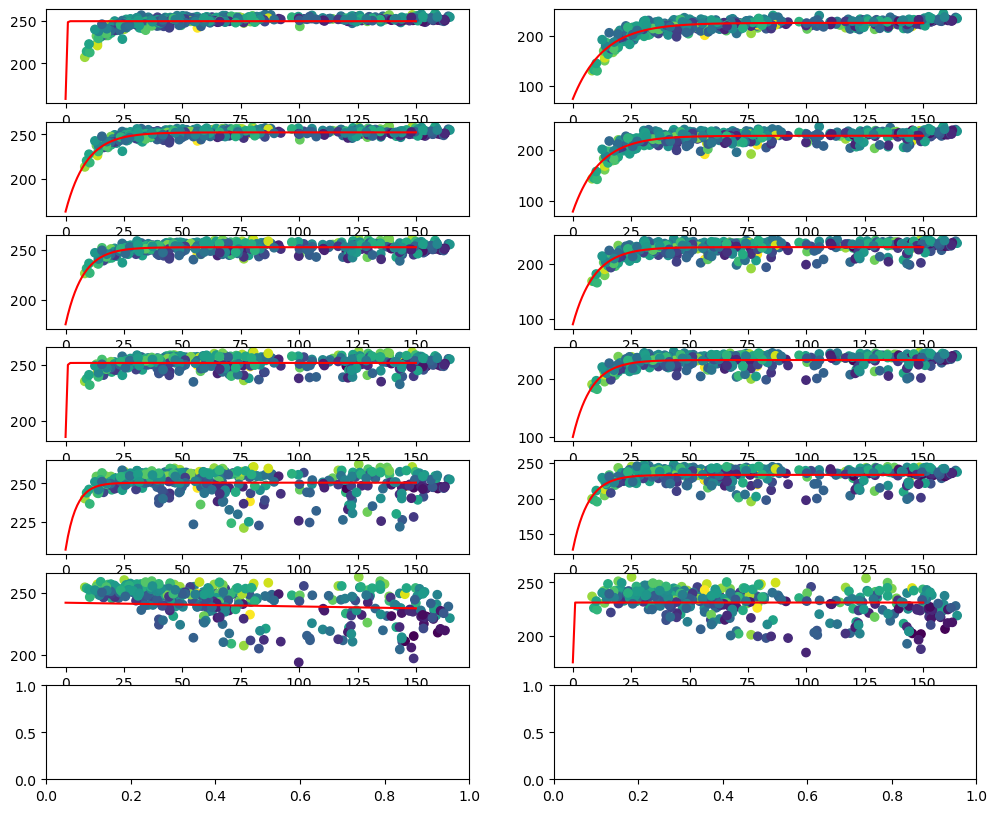

In [106]:
fig,axs=plt.subplots(nrows=7,ncols=2,figsize=(12,10))
#scatter(fulltable[!,:SIT],fulltable[!,"10.7H"])
channels=["6.9V","6.9H","10.7V","10.7H","18.7V","18.7H","23.8V","23.8H","36.5V","36.5H","89.0V","89.0H"]
owtp=[157.9397756705356
  74.22054192317813
 163.4896743050617
  78.40477088765373
 175.18191921420814
  90.60124656474672
 185.91398347505353
  99.89685544430296
 206.667948239106
 128.36037504633393
 242.01900700540162
 175.158277073163]
for i=1:12
    nanidx=.!isnan.(fulltable[!,channels[i]])
    axs.flat[i-1].scatter(fulltable[nanidx,:newSIT],fulltable[nanidx,channels[i]],c=fulltable[nanidx,:strd],cmap="viridis")
    cf(x,pp)=ff([owtp[i],pp[1],pp[2]]).(x)
    hp=curve_fit(cf,fulltable[nanidx,:newSIT],fulltable[nanidx,channels[i]],[200,2.0]).param
    hp=[owtp[i],hp...]
    #println(hp[3])
    #axs[p].scatter(fulltable[!,:newSIT].* 100,fulltable[!,channels[i]])
    xx=collect(0:1:150)
    axs.flat[i-1].plot(xx,ff(hp).(xx),color="red")
    #plt.colorbar(axs.flat[i])
end
gcf()

In [60]:
ax=axs.flat[1]
ax.

# 1 method for callable object:
[1] (f::PythonCall.Py)(args...; kwargs...) in PythonCall at /home/huntemann/.julia/packages/PythonCall/3GRYN/src/Py.jl:352

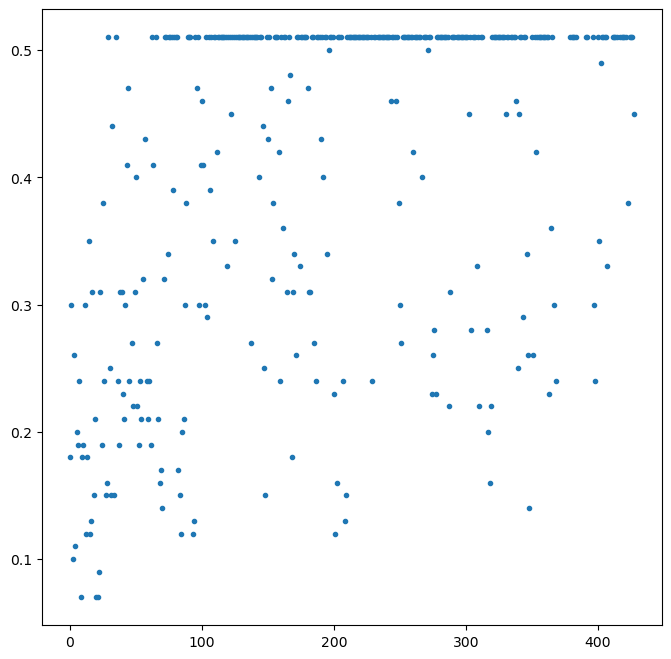

In [61]:

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(fulltable[!,:SIT],".")
display(MIME("image/png"),fig)

In [16]:
fulltable[!,"89.0V"]

428-element Vector{Union{Missing, Float64}}:
 260.13
 252.67
 249.11
 252.43
 256.74
 254.77
 256.26
 253.64
 254.35
 257.36
   ⋮
 249.14
 245.31
 246.91
 206.19
 230.59
 242.02
 220.73
 229.81
 249.2

In [17]:
fn="../data/THINICE_SIC1-AMSR-N_wsmos.text"
mdf=CSV.read(fn,DataFrame)
sit=mdf[!,6]
for i=1:43
    println("$i $(names(mdf)[i])")
end

1 # lat
2 lon
3 timestamp
4 referenceID
5 SIC
6 thin-ice thickness
7 thin-ice thickness std
8 lat
9 lon_1
10 timestamp_1
11 sensorID
12 6.9V
13 6.9H
14 10.7V
15 10.7H
16 18.7V
17 18.7H
18 23.8V
19 23.8H
20 36.5V
21 36.5H
22 89.0V
23 89.0H
24 upstream-file
25 1.4HV10
26 1.4H3035
27 1.4V3035
28 1.4H4050
29 1.4V4050
30 1.4H5055
31 1.4V5055
32 1.4H5456
33 1.4V5456
34 1.4HV10std
35 1.4H3035std
36 1.4V3035std
37 1.4H4050err
38 1.4V4050err
39 1.4H5055std
40 1.4V5055std
41 1.4H5456std
42 1.4V5456std
43 SMOS_SIT


In [18]:
@. ff(x,p)=p[2]-(p[2]-p[1])*exp(-x/p[3])
sit=mdf[!,6]

idx= .!(sit==-999) .& .!(sit.>0.5)

28740-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1

8.956615582385908
11.894364589753874
8.52431046569442
11.645437092902535
7.734378368070544
10.165054195271782
7.473947263410875
9.128550147675183
7.6681838621416425
8.98643673857489
2.8041750136460695
5.686319297256588


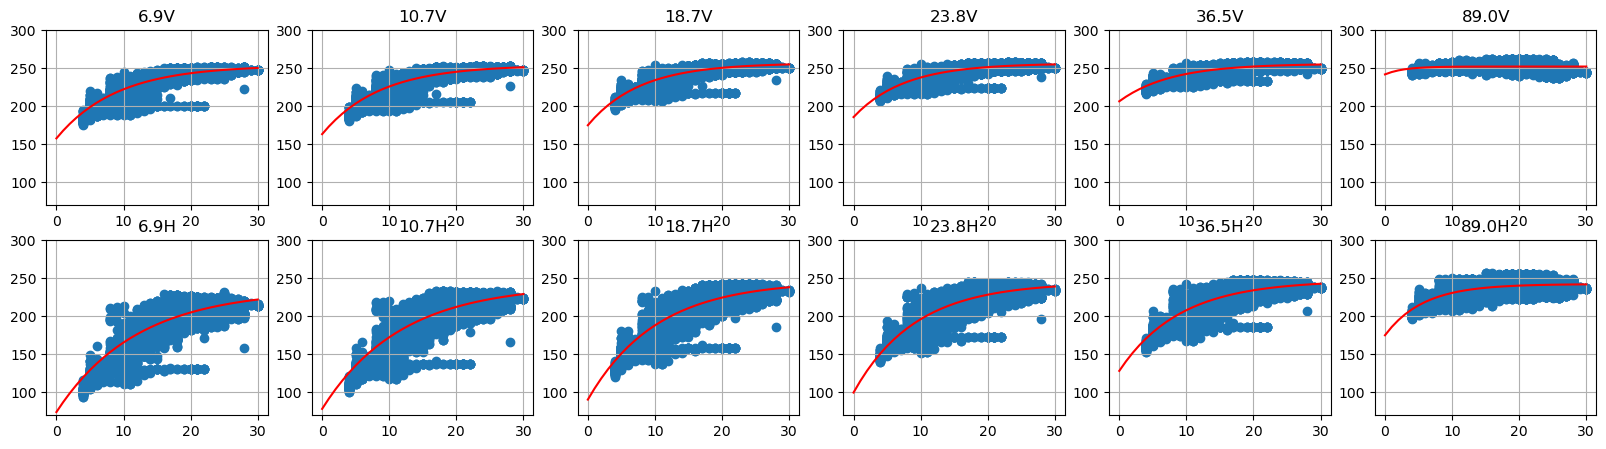

In [48]:
fig,axs=plt.subplots(figsize=(20,5),nrows=2,ncols=6)
axs=pyconvert(Array,axs)
owtp=[157.9397756705356
  74.22054192317813
 163.4896743050617
  78.40477088765373
 175.18191921420814
  90.60124656474672
 185.91398347505353
  99.89685544430296
 206.667948239106
 128.36037504633393
 242.01900700540162
 175.158277073163] #ow tiepoints
for p=1:12
    #println(p)
    index=11+p
#idexes=
    dv=mdf[!,index]
    name=names(mdf)[index]
    cf(x,pp)=ff(x,[owtp[p],pp[1],pp[2]])
    hp=curve_fit(cf,sit.*100,dv,[200,2.0]).param
    hp=[owtp[p],hp...]
    #println(hp[3])
    axs[p].scatter(sit.* 100,dv)
    xx=collect(0:1:30)
    axs[p].plot(xx,ff.(xx,Ref(hp)),color="red")
    axs[p].set_title(name)
    axs[p].set_ylim(70,300)
    axs[p].grid()
end
display(MIME("image/png"),fig)

In [21]:
fulltable.SIT

428-element Vector{Float64}:
    0.18
    0.3
    0.1
    0.26
    0.11
    0.2
    0.19
    0.24
    0.07
    0.18
    ⋮
    0.51
    0.51
    0.51
 -999.0
    0.38
    0.51
    0.51
    0.51
    0.45